In [1]:
%matplotlib inline


Rhythmic Entrainment Source Separation (RESS) example
=====================================================

Find the linear combinations of multichannel data that maximize the
signal-to-noise ratio of the narrow-band steady-state response in the frequency
domain.

Uses `meegkit.RESS()`.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as ss

from meegkit import ress
from meegkit.utils import unfold, rms, fold

#import config

np.random.seed(1)

Create synthetic data
-----------------------------------------------------------------------------
Create synthetic data containing a single oscillatory component at 12 hz.



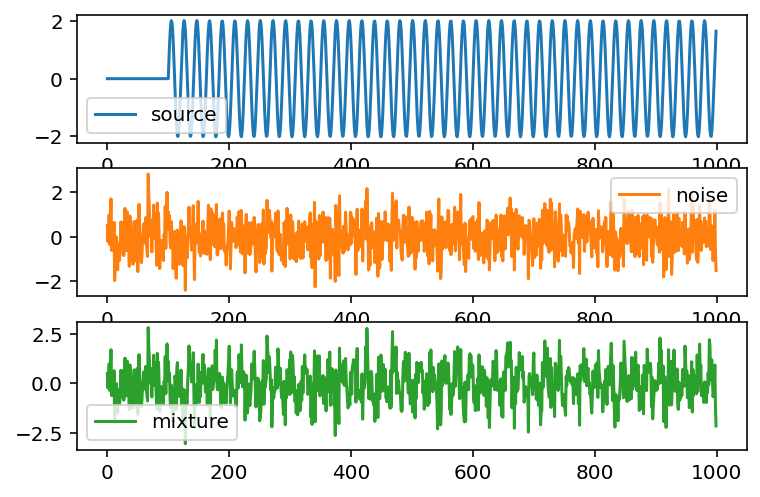

In [3]:
n_times = 1000
n_chans = 10
n_trials = 50
target = 12
sfreq = 250
noise_dim = 8
SNR = 1.
t0 = 100

# source
source = np.sin(2 * np.pi * target * np.arange(n_times - t0) / sfreq)[None].T
s = source * np.random.randn(1, n_chans)
s = s[:, :, np.newaxis]
s = np.tile(s, (1, 1, n_trials))
signal = np.zeros((n_times, n_chans, n_trials))
signal[t0:, :, :] = s

# noise
noise = np.dot(
    unfold(np.random.randn(n_times, noise_dim, n_trials)),
    np.random.randn(noise_dim, n_chans))
noise = fold(noise, n_times)

# mix signal and noise
signal = SNR * signal / rms(signal.flatten())
noise = noise / rms(noise.flatten())
data = signal + noise

# Plot
f, ax = plt.subplots(3)
ax[0].plot(signal[:, 0, 0], c='C0', label='source')
ax[1].plot(noise[:, 1, 0], c='C1', label='noise')
ax[2].plot(data[:, 1, 0], c='C2', label='mixture')
ax[0].legend()
ax[1].legend()
ax[2].legend()

Enhance oscillatory activity using RESS
-----------------------------------------------------------------------------



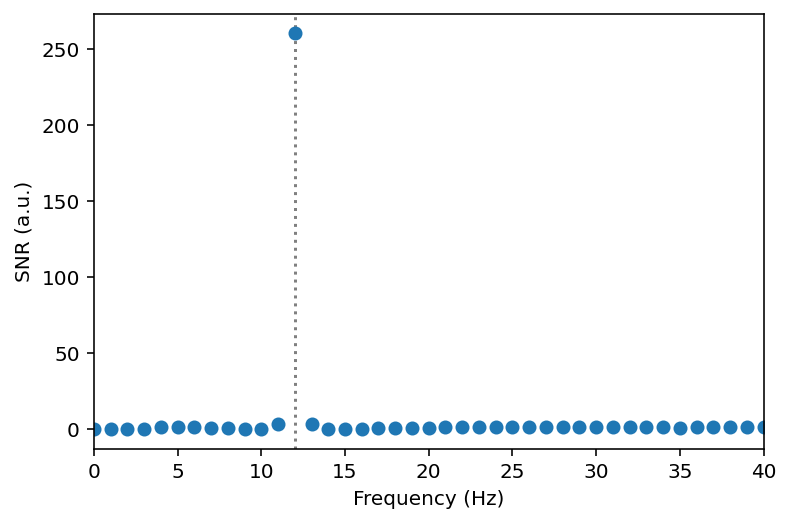

In [4]:
# Apply RESS
out = ress.RESS(data, sfreq=sfreq, peak_freq=target)

# Compute PSD
nfft = 250
df = sfreq / nfft  # frequency resolution
bins, psd = ss.welch(out, sfreq, window="hamming", nperseg=nfft,
                        noverlap=125, axis=0)
psd = psd.mean(axis=1)  # average over trials

# Loop over frequencies and compute SNR
skipbins = 1            # skip bins directly next to frequency of interest
n_bins = int(3 / df)    # number of bins to average over
snr = np.zeros(len(bins))
for ibin in range(n_bins + 1, len(bins) - n_bins - 1):
    numer = psd[ibin]
    irange = np.r_[np.arange(ibin - n_bins, ibin - skipbins),
                    np.arange(ibin + skipbins + 1, ibin + n_bins)]
    denom = np.mean(psd[irange])
    snr[ibin] = numer / denom  # divide amplitude at peak by neighbours

f, ax = plt.subplots(1)
ax.plot(bins, snr, 'o')
ax.axvline(target, ls=':', c='grey', zorder=0)
ax.set_ylabel('SNR (a.u.)')
ax.set_xlabel('Frequency (Hz)')
ax.set_xlim([0, 40])
plt.show()